# **Install Dependencies**

In [1]:
# 📦 Install dependencies
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -q pycocotools

# 🔧 Setup: Import
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
from matplotlib import pyplot as plt

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wbjscmyc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wbjscmyc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6434843 sha256=e0dafcfb78c930aadcc463537656df1e36bb05ea4c639793bcc469f488cc54aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhssq76w/wheels/17/d9/40/60db98e485aa9455d

# **Register Dataset**

In [2]:
# Set root folder di Google Drive
dataset_root = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new"

# Buat path lengkap ke JSON dan folder gambar
train_json = os.path.join(dataset_root, "train/_annotations.coco.json")
val_json = os.path.join(dataset_root, "valid/_annotations.coco.json")
test_json = os.path.join(dataset_root, "test/_annotations.coco.json")
train_img_dir = os.path.join(dataset_root, "train")
val_img_dir = os.path.join(dataset_root, "valid")
test_img_dir = os.path.join(dataset_root, "test")

# ✅ Cek apakah file dan folder ada
print("Train JSON exists:", os.path.exists(train_json))
print("Train Image Dir exists:", os.path.exists(train_img_dir))

# 🗂 Daftarkan dataset ke Detectron2
register_coco_instances("roboflow_train", {}, train_json, train_img_dir)
register_coco_instances("roboflow_val", {}, val_json, val_img_dir)
register_coco_instances("roboflow_test_1", {}, test_json, test_img_dir)

Train JSON exists: True
Train Image Dir exists: True


# **Konfigurasi Model**

In [ ]:
from detectron2 import model_zoo

# 🧠 Configure RetinaNet
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roboflow_train",)
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 2800
cfg.TEST.EVAL_PERIOD = 500  # Evaluate every 500 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.RETINANET.NUM_CLASSES = 4  # ⚠️ Update this if more than 1 class
# ⬅️ Tambahkan ini untuk mendukung Adam optimizer
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.0
cfg.OUTPUT_DIR = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# **Training Skenario 2**

In [ ]:
from detectron2.engine.hooks import BestCheckpointer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import EventStorage

import torch

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Override default SGD optimizer with Adam
        """
        params = []
        for key, value in model.named_parameters():
            if not value.requires_grad:
                continue
            lr = cfg.SOLVER.BASE_LR
            weight_decay = cfg.SOLVER.WEIGHT_DECAY
            # Bias parameter biasanya dikurangi decay-nya
            if "bias" in key:
                weight_decay = cfg.SOLVER.WEIGHT_DECAY_BIAS
            params += [{"params": [value], "lr": lr, "weight_decay": weight_decay}]

        optimizer = torch.optim.Adam(params, lr=cfg.SOLVER.BASE_LR)
        return optimizer

    def build_hooks(self):
        hooks = super().build_hooks()
        # Save the best checkpoint based on bbox/AP
        hooks.insert(
            -1,
            BestCheckpointer(
                cfg.TEST.EVAL_PERIOD,
                checkpointer=DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                val_metric="bbox/AP",
                mode="max",
                file_prefix="best_model"
            )
        )
        return hooks

# Inisialisasi trainer dan mulai training
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/14 10:50:16 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

R-50.pkl: 102MB [00:02, 47.1MB/s]                            


[06/14 10:50:19 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/14 10:50:19 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54


backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
backbone.top_block.p6.{bias, weight}
backbone.top_block.p7.{bias, weight}
head.bbox_pred.{bias, weight}
head.bbox_subnet.0.{bias, weight}
head.bbox_subnet.2.{bias, weight}
head.bbox_subnet.4.{bias, weight}
head.bbox_subnet.6.{bias, weight}
head.cls_score.{bias, weight}
head.cls_subnet.0.{bias, weight}
head.cls_subnet.2.{bias, weight}
head.cls_subnet.4.{bias, weight}
head.cls_subnet.6.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[06/14 10:50:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/14 10:51:35 d2.utils.events]:  eta: 2:37:04  iter: 19  total_loss: 2.465  loss_cls: 1.496  loss_box_reg: 0.9506    time: 3.5540  last_time: 3.6926  data_time: 1.7019  last_data_time: 1.7316   lr: 1.9981e-06  max_mem: 7609M
[06/14 10:52:49 d2.utils.events]:  eta: 2:38:44  iter: 39  total_loss: 1.835  loss_cls: 1.141  loss_box_reg: 0.7127    time: 3.5301  last_time: 3.6841  data_time: 1.5290  last_data_time: 1.6861   lr: 3.9961e-06  max_mem: 7609M
[06/14 10:53:53 d2.utils.events]:  eta: 2:37:22  iter: 59  total_loss: 1.847  loss_cls: 1.119  loss_box_reg: 0.7153    time: 3.4224  last_time: 2.1464  data_time: 1.1685  last_data_time: 0.0652   lr: 5.9941e-06  max_mem: 7609M
[06/14 10:54:36 d2.utils.events]:  eta: 2:34:06  iter: 79  total_loss: 1.65  loss_cls: 0.9733  loss_box_reg: 0.6884    time: 3.1024  last_time: 2.1639  data_time: 0.0732  last_data_time: 0.0658   lr: 7.9921e-06  max_mem: 7609M
[06/14 10:55:20 d2.utils.events]:  eta: 2:30:30  iter: 99  total_loss: 1.408  loss_cls: 0.78

# **Simpan Konfigurasi Model**

In [ ]:
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

# **Prediksi**

[06/14 12:33:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth ...


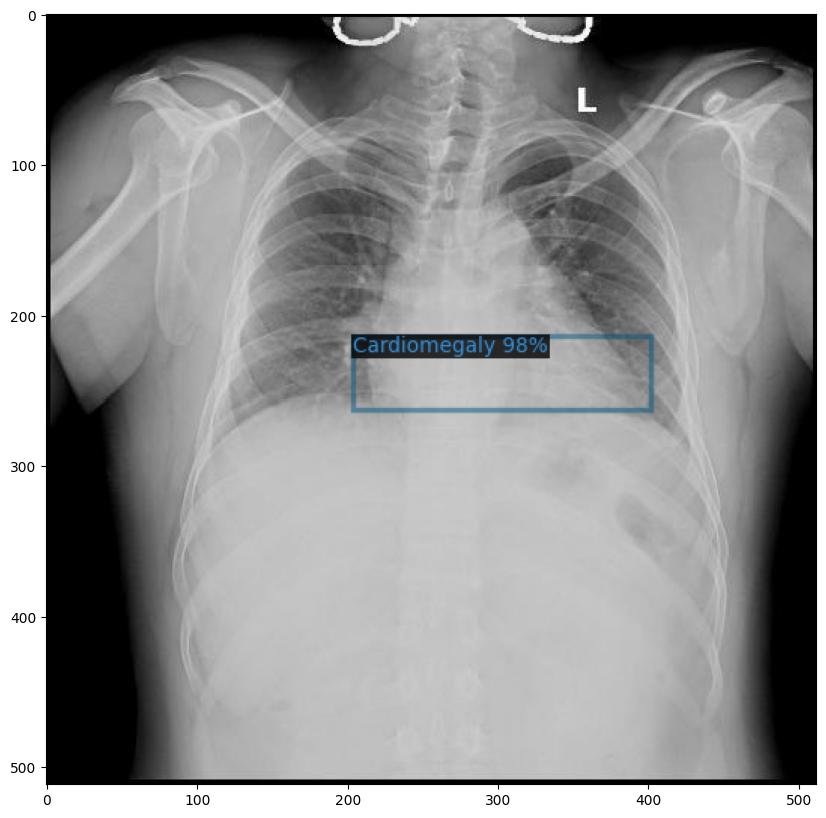

Detected 1 objects with confidence > 50.0%.


In [ ]:
# 🧠 Load the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # Load the weights from your training
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set threshold to 50% for detection

from detectron2.engine import DefaultPredictor

predictor = DefaultPredictor(cfg)

# 📸 Read the image
#image_path = '/content/valid/00000732_005_jpg.rf.3541c4c659fec2d5d003b4fb7a380dea.jpg'
image_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/test/9ed1f91369552618456da255b02820b3_jpg.rf.17cd671024249e0b1f3a9e36be41a928.jpg"
im = cv2.imread(image_path)

# 🧠 Run inference
outputs = predictor(im)

# Filter instances with confidence
confidence = 0.5
instances = outputs["instances"]
scores = instances.scores
filtered_instances = instances[scores > confidence]

# 🖼️ Visualize the results
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("roboflow_train"), scale=1)
v = v.draw_instance_predictions(filtered_instances.to("cpu"))

# Show the image with filtered instances
plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.show()

# Optionally, print out the number of detections
print(f"Detected {len(filtered_instances)} objects with confidence > {confidence*100}%.")


# **Prediksi VS GT**

head.cls_score.{bias, weight}


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


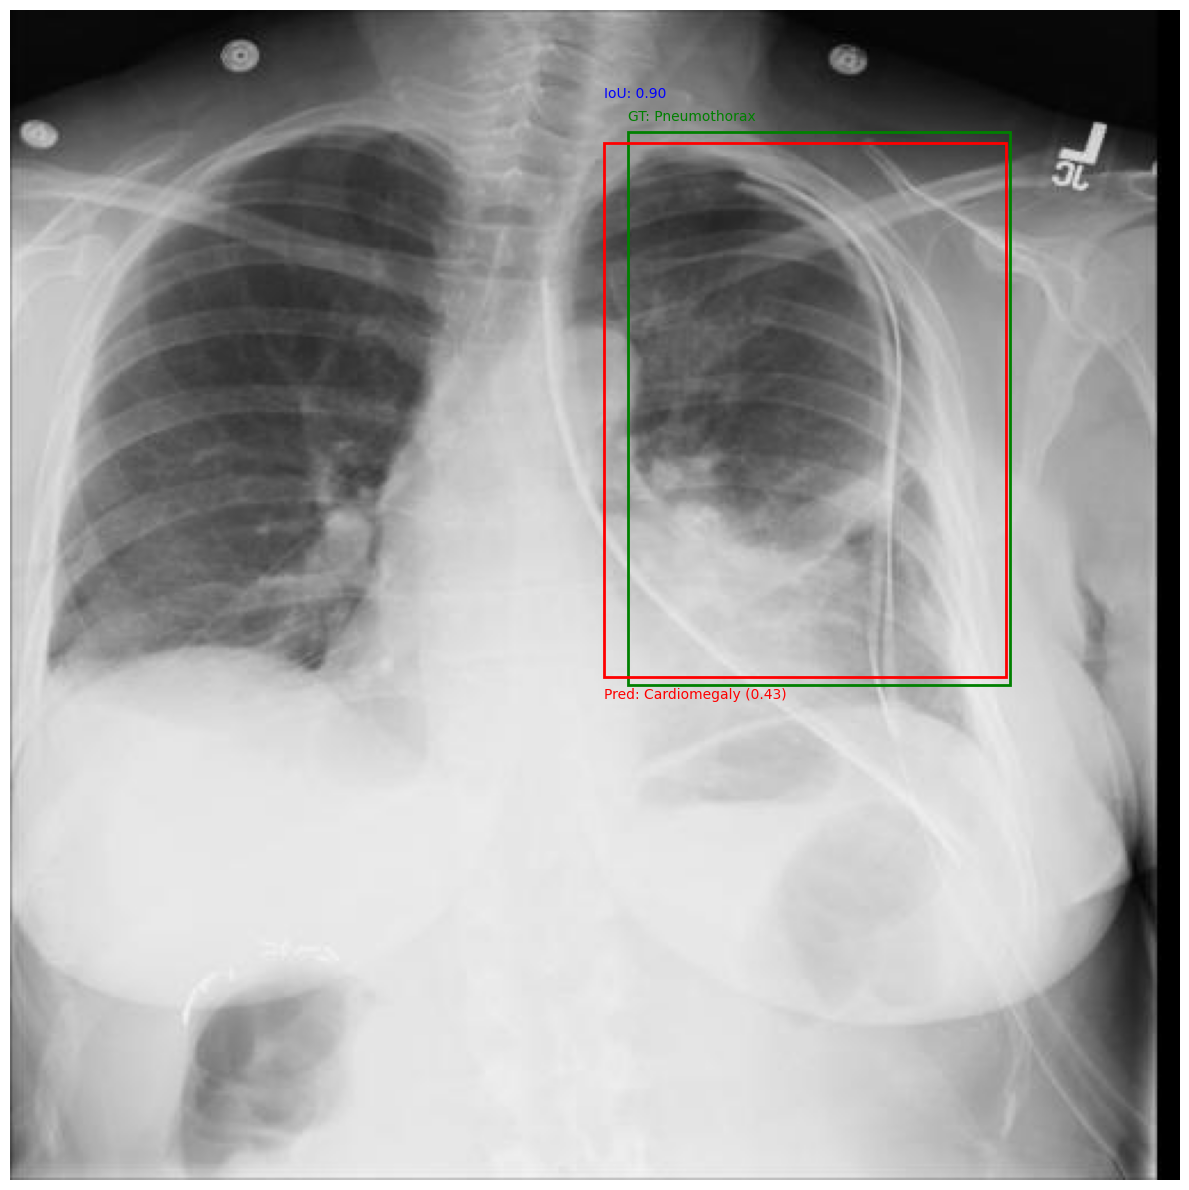

Detected 1 objects with confidence > 40%.


In [60]:
import os
import cv2
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances

# === Daftarkan Dataset COCO dengan metadata ===
register_coco_instances(
    "roboflow_test",
    {
        "thing_classes": ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]  # ganti sesuai kategori di COCO kamu
    },
    "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json",
    "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test"
)

# === Load Konfigurasi Model Detectron2 ===
# === Konfigurasi Model ===
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/epoch_50_1e-4_Adam/config.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 3  # ganti sesuai jumlah kelas
cfg.MODEL.SCORE_THRESH_TEST = 0.4
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATASETS.TEST = ("roboflow_test",)  # ganti sesuai nama dataset
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/epoch_50_1e-4_Adam/best_model.pth"
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("roboflow_test")  # ganti sesuai nama dataset kamu

# === Load COCO Annotations ===
annotation_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json"  # ganti path sesuai file .json kamu
coco = COCO(annotation_path)

# === Load 1 Gambar dan GT ===
image_ids = coco.getImgIds()
image_id = image_ids[5]  # pakai ID pertama yang tersedia
image_info = coco.loadImgs(image_id)[0]
image_path = os.path.join(
    "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test",
    image_info['file_name']
)

image = cv2.imread(image_path)
image_rgb = image[..., ::-1]

# Ground truth boxes & labels
ann_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(ann_ids)

gt_boxes = []
gt_labels = []
for ann in annotations:
    x, y, w, h = ann['bbox']
    gt_boxes.append([x, y, x + w, y + h])
    gt_labels.append(ann['category_id'] - 1)  # pastikan label index mulai dari 0

# === Predict ===
outputs = predictor(image)
instances = outputs["instances"]
scores = instances.scores
pred_boxes = instances.pred_boxes.tensor.cpu().numpy()
pred_labels = instances.pred_classes.cpu().numpy()
pred_scores = scores.cpu().numpy()

# === Filter prediksi berdasarkan confidence threshold ===
confidence = 0.4
keep = pred_scores > confidence
pred_boxes = pred_boxes[keep]
pred_labels = pred_labels[keep]
pred_scores = pred_scores[keep]

# === Fungsi IoU ===
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = area1 + area2 - inter

    return inter / union if union > 0 else 0

# === Visualisasi ===
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(image_rgb)

# --- Gambar GT (hijau) ---
for box, label in zip(gt_boxes, gt_labels):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, f"GT: {metadata.thing_classes[label]}", color='green', fontsize=10)

# --- Gambar Prediksi (merah) + IoU ---
for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymax + 10, f"Pred: {metadata.thing_classes[label]} ({score:.2f})", color='red', fontsize=10)

    # IoU dengan semua GT
    for gt_box in gt_boxes:
        iou = calculate_iou(box, gt_box)
        if iou > 0.5:
            ax.text(xmin, ymin - 20, f"IoU: {iou:.2f}", color='blue', fontsize=10)
            break

plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Detected {len(pred_boxes)} objects with confidence > {confidence*100:.0f}%.")


In [18]:
image_ids = coco.getImgIds()
print(image_ids[:5])  # tampilkan 5 ID pertama


[0, 1, 2, 3, 4]


# **Grafik Record Training**

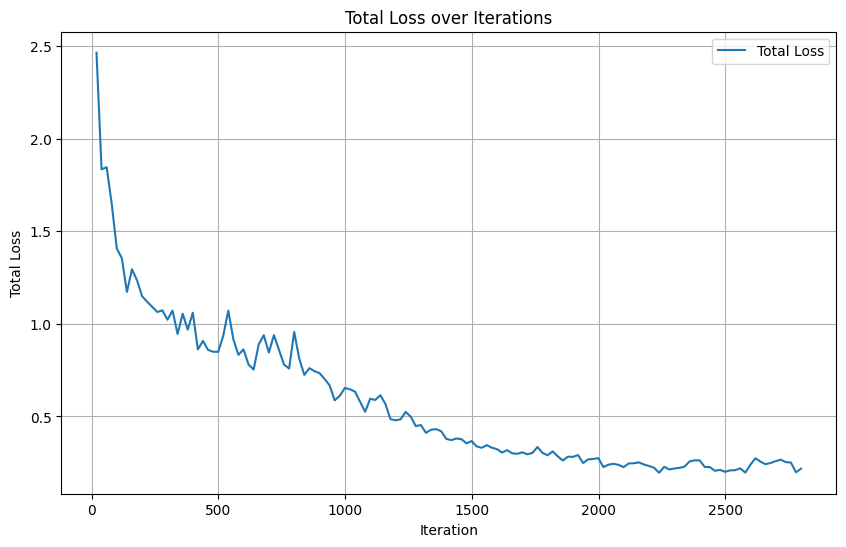

In [ ]:
import json
import matplotlib.pyplot as plt

# Tentukan path ke file metrics.json
metrics_file = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/metrics.json'  # Ganti dengan path file Anda

# Menyaring data untuk total_loss
iterations = []
total_loss = []

# Membaca file JSON baris per baris
with open(metrics_file, 'r') as f:
    for line in f:
        # Memuat setiap baris JSON
        entry = json.loads(line)

        # Menyaring data untuk iteration dan total_loss
        if 'iteration' in entry and 'total_loss' in entry:
            iterations.append(entry['iteration'])
            total_loss.append(entry['total_loss'])

# Membuat grafik untuk total loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss, label="Total Loss", color='tab:blue')

# Menambahkan judul dan label sumbu
plt.title('Total Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.grid(True)

# Menampilkan grafik
plt.legend()
plt.show()

Total data points: 6


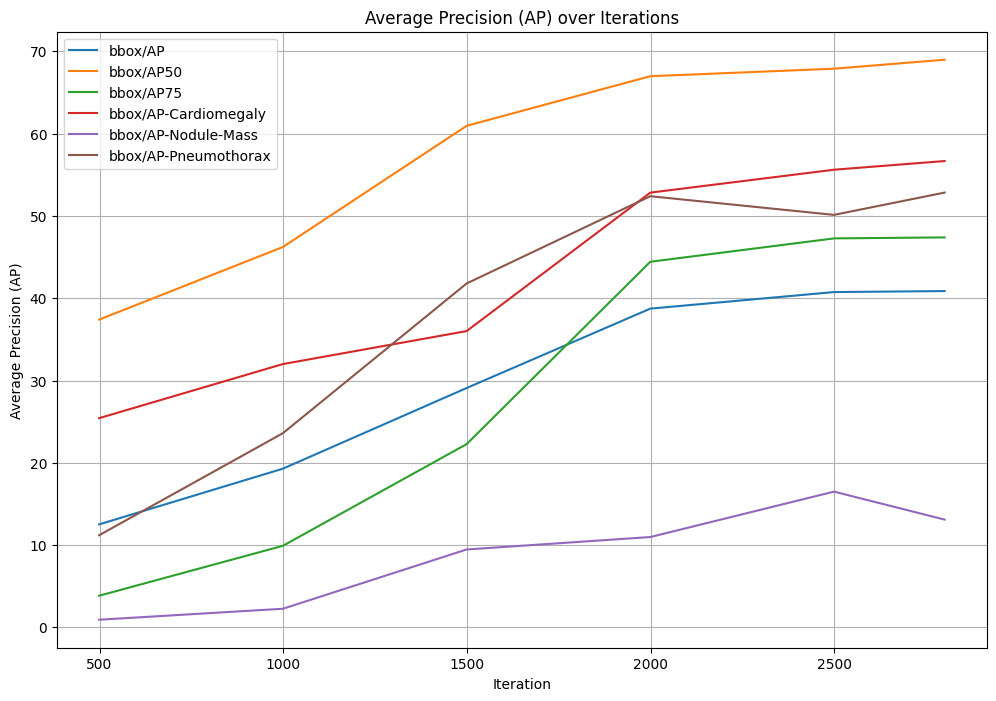

In [ ]:
import json
import matplotlib.pyplot as plt

# Tentukan path ke file metrics.json
metrics_file = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/metrics.json'  # Ganti dengan path file Anda

# Menyaring data untuk AP
iterations = []
bbox_ap = []
bbox_ap50 = []
bbox_ap75 = []
bbox_ap_cardio = []
bbox_ap_nodule = []
bbox_ap_pneumo = []

# Membaca file JSON baris per baris
with open(metrics_file, 'r') as f:
    for line in f:
        try:
            entry = json.loads(line)

            # Pastikan hanya memasukkan data yang mengandung metrik 'bbox/AP'
            if 'bbox/AP' in entry:
                iterations.append(entry['iteration'])
                bbox_ap.append(entry['bbox/AP'])
                bbox_ap50.append(entry.get('bbox/AP50', None))
                bbox_ap75.append(entry.get('bbox/AP75', None))
                bbox_ap_cardio.append(entry.get('bbox/AP-Cardiomegaly', None))
                bbox_ap_nodule.append(entry.get('bbox/AP-Nodule-Mass', None))
                bbox_ap_pneumo.append(entry.get('bbox/AP-Pneumothorax', None))

        except json.JSONDecodeError as e:
            print(f"Error parsing line: {e}")
            continue

# Memastikan ada data untuk plotting
print(f"Total data points: {len(iterations)}")

# Jika ada data untuk plotting, buat grafik
if iterations:
    plt.figure(figsize=(12, 8))

    # Plotting berbagai metrik AP
    plt.plot(iterations, bbox_ap, label="bbox/AP", color='tab:blue')
    plt.plot(iterations, bbox_ap50, label="bbox/AP50", color='tab:orange')
    plt.plot(iterations, bbox_ap75, label="bbox/AP75", color='tab:green')
    plt.plot(iterations, bbox_ap_cardio, label="bbox/AP-Cardiomegaly", color='tab:red')
    plt.plot(iterations, bbox_ap_nodule, label="bbox/AP-Nodule-Mass", color='tab:purple')
    plt.plot(iterations, bbox_ap_pneumo, label="bbox/AP-Pneumothorax", color='tab:brown')

    # Menambahkan judul dan label sumbu
    plt.title('Average Precision (AP) over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Average Precision (AP)')
    plt.grid(True)

    # Menampilkan legenda
    plt.legend()

    # Menampilkan grafik
    plt.show()
else:
    print("Tidak ada data untuk plot.")


In [ ]:
import json

# Menentukan path file metrics.json di Google Drive
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/metrics.json'

# Memuat file metrics.json
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()]

# Menyaring nilai AP per kelas dari data terakhir
metrics = data[-1]  # Mengambil data terakhir yang berisi AP

# Mengambil nilai AP per kelas
ap_values = {
    "Cardiomegaly": metrics.get('bbox/AP-Cardiomegaly', 0),
    "Nodule-Mass": metrics.get('bbox/AP-Nodule-Mass', 0),
    "Pneumothorax": metrics.get('bbox/AP-Pneumothorax', 0),
}

# Menghitung mAP (mean Average Precision)
ap_values_list = list(ap_values.values())
map_score = sum(ap_values_list) / len(ap_values_list)

# Menampilkan hasil
print("AP per kelas:")
for class_name, ap in ap_values.items():
    print(f"{class_name}: {ap:.4f}")

print(f"\nmAP: {map_score:.4f}")


AP per kelas:
Cardiomegaly: 56.6733
Nodule-Mass: 13.0991
Pneumothorax: 52.8414

mAP: 40.8713


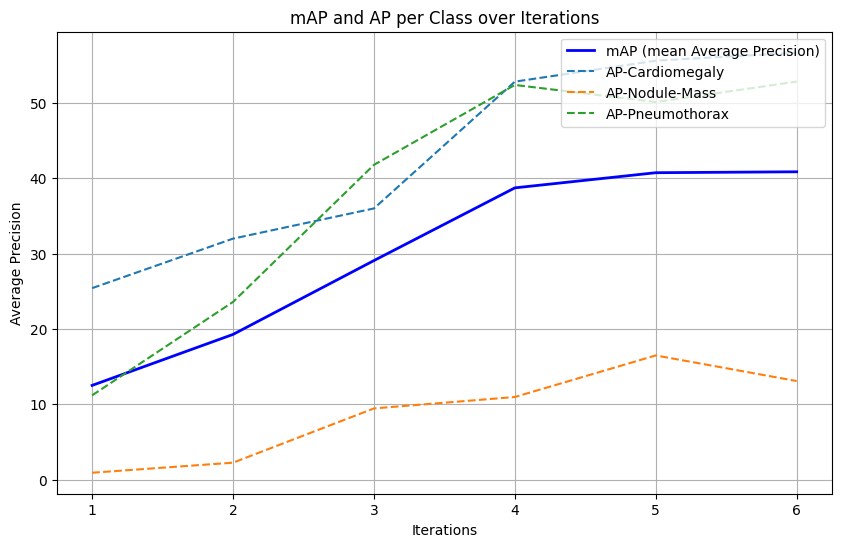

In [ ]:
import json
import matplotlib.pyplot as plt

# Menentukan path file metrics.json (update dengan path yang sesuai)
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/metrics.json'

# Memuat file metrics.json
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()]

# Menyaring nilai AP per kelas dari data terakhir
ap_per_iteration = []
map_per_iteration = []

# Menyaring nilai AP per kelas dan mAP dari setiap iterasi
for metrics in data:
    # Mengecek apakah nilai AP ada dalam data
    if 'bbox/AP-Cardiomegaly' in metrics and 'bbox/AP-Nodule-Mass' in metrics and 'bbox/AP-Pneumothorax' in metrics:
        ap_values = {
            "Cardiomegaly": metrics.get('bbox/AP-Cardiomegaly', 0),
            "Nodule-Mass": metrics.get('bbox/AP-Nodule-Mass', 0),
            "Pneumothorax": metrics.get('bbox/AP-Pneumothorax', 0),
        }

        # Menghitung mAP (mean Average Precision)
        ap_values_list = list(ap_values.values())
        map_score = sum(ap_values_list) / len(ap_values_list)

        ap_per_iteration.append(ap_values)
        map_per_iteration.append(map_score)

# Menyiapkan data untuk grafik
iterations = range(1, len(map_per_iteration) + 1)

# Plotting mAP per iterasi
plt.figure(figsize=(10, 6))
plt.plot(iterations, map_per_iteration, label='mAP (mean Average Precision)', color='blue', linewidth=2)

# Menambahkan grafik untuk setiap kelas
for class_name in ap_per_iteration[0].keys():
    class_ap_values = [ap[class_name] for ap in ap_per_iteration]
    plt.plot(iterations, class_ap_values, label=f'AP-{class_name}', linestyle='--')

# Menambahkan label dan judul
plt.xlabel('Iterations')
plt.ylabel('Average Precision')
plt.title('mAP and AP per Class over Iterations')
plt.legend(loc='upper right')

# Menampilkan grafik
plt.grid(True)
plt.show()


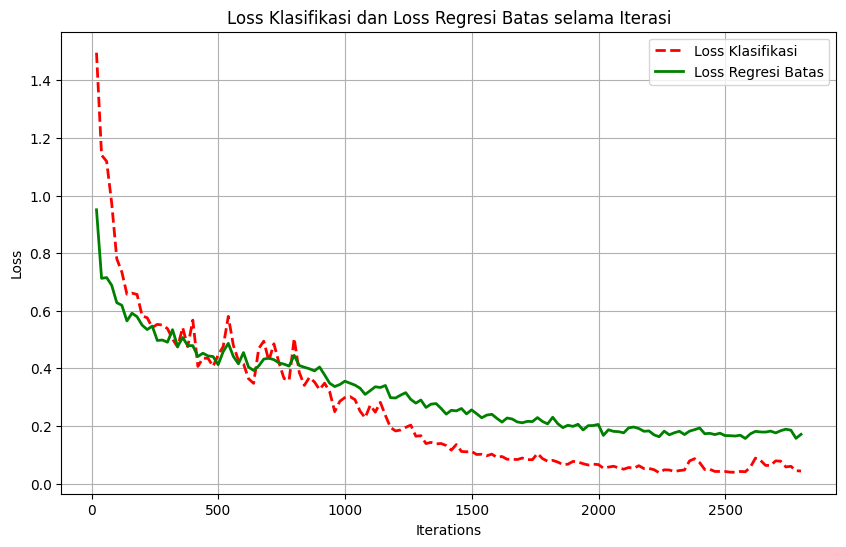

In [ ]:
import matplotlib.pyplot as plt
import json

# Path file di Google Drive (sesuaikan dengan path file Anda)
file_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/metrics.json'

# Memuat data dari file metrics.json
with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]

# Menyiapkan data untuk plot
iterations = []
loss_cls_values = []
loss_box_reg_values = []

# Looping untuk mengekstrak data
for metrics in data:
    # Pastikan ada key yang dibutuhkan
    if 'iteration' in metrics:
        iterations.append(metrics['iteration'])
    if 'loss_cls' in metrics:
        loss_cls_values.append(metrics['loss_cls'])
    if 'loss_box_reg' in metrics:
        loss_box_reg_values.append(metrics['loss_box_reg'])

# Pastikan panjang data sama, dan jika tidak, sesuaikan panjangnya
min_len = min(len(iterations), len(loss_cls_values), len(loss_box_reg_values))

# Potong data agar memiliki panjang yang sama
iterations = iterations[:min_len]
loss_cls_values = loss_cls_values[:min_len]
loss_box_reg_values = loss_box_reg_values[:min_len]

# Membuat plot jika data ada
if iterations and loss_cls_values and loss_box_reg_values:
    plt.figure(figsize=(10, 6))

    # Plot Loss Klasifikasi
    plt.plot(iterations, loss_cls_values, label='Loss Klasifikasi', color='red', linestyle='--', linewidth=2)

    # Plot Loss Regresi Batas
    plt.plot(iterations, loss_box_reg_values, label='Loss Regresi Batas', color='green', linestyle='-', linewidth=2)

    # Menambahkan label dan judul
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Klasifikasi dan Loss Regresi Batas selama Iterasi')

    # Menambahkan legend
    plt.legend(loc='upper right')

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()
else:
    print("Data tidak lengkap, pastikan key 'loss_cls' dan 'loss_box_reg' ada dalam setiap entri.")


# **Confusion Matrix**

In [ ]:
def calculate_iou(box1, box2):
    """
    box: [xmin, ymin, xmax, ymax]
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    else:
        return inter_area / union_area


[06/14 12:35:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth ...


Processing Test Images: 100%|██████████| 111/111 [00:12<00:00,  8.57it/s]


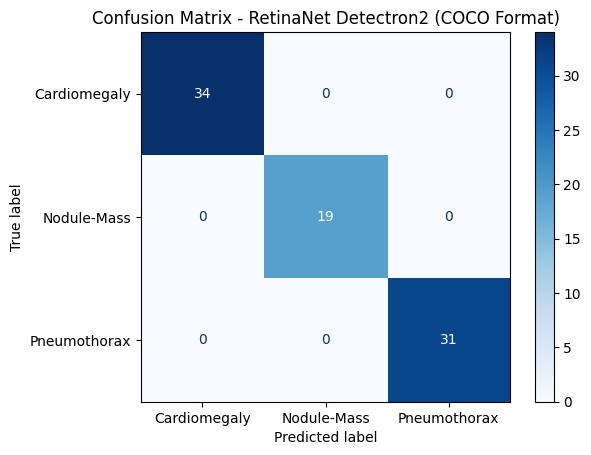

In [ ]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🧠 Load model
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth"
predictor = DefaultPredictor(cfg)

# 📚 Prepare dataset paths
test_image_dir = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test"
coco_annotation_path = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json"

# Load COCO ground truth
with open(coco_annotation_path) as f:
    coco_data = json.load(f)

# Build image_id to filename mapping
id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Build annotations mapping
annotations = coco_data['annotations']
gt_dict = {}  # {filename: (boxes, labels)}

for ann in annotations:
    image_id = ann['image_id']
    filename = id_to_filename[image_id]
    bbox = ann['bbox']  # [x, y, width, height]
    category_id = ann['category_id']

    if filename not in gt_dict:
        gt_dict[filename] = {'boxes': [], 'labels': []}

    # Convert bbox format to [xmin, ymin, xmax, ymax]
    xmin, ymin, w, h = bbox
    xmax = xmin + w
    ymax = ymin + h

    gt_dict[filename]['boxes'].append([xmin, ymin, xmax, ymax])
    gt_dict[filename]['labels'].append(category_id)

# Build category_id to class_name mapping
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
class_names = [category_id_to_name[i] for i in sorted(category_id_to_name.keys())]

# 🔥 Start evaluating
y_true = []
y_pred = []
iou_threshold = 0.5
confidence_threshold = 0.5

test_images = sorted(os.listdir(test_image_dir))
test_images = [img for img in test_images if img.endswith('.jpg') or img.endswith('.png')]

for img_file in tqdm(test_images, desc="Processing Test Images"):
    # Read image
    img_path = os.path.join(test_image_dir, img_file)
    img = cv2.imread(img_path)

    if img_file not in gt_dict:
        continue  # skip images without ground truth

    gt_boxes = np.array(gt_dict[img_file]['boxes'])
    gt_classes = np.array(gt_dict[img_file]['labels'])

    # Predict
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    pred_boxes = instances.pred_boxes.tensor.numpy()
    pred_classes = instances.pred_classes.numpy()
    pred_scores = instances.scores.numpy()

    # Filter predictions by confidence
    keep = pred_scores > confidence_threshold
    pred_boxes = pred_boxes[keep]
    pred_classes = pred_classes[keep]

    matched_gt = set()

    # Matching predicted boxes to ground truth boxes
    for pred_box, pred_class in zip(pred_boxes, pred_classes):
        best_iou = 0
        best_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou and idx not in matched_gt:
                best_iou = iou
                best_idx = idx
        if best_iou >= iou_threshold and best_idx != -1:
            y_true.append(gt_classes[best_idx])
            y_pred.append(pred_class)
            matched_gt.add(best_idx)
        else:
            # False positive
            y_true.append(-1)  # background
            y_pred.append(pred_class)

    # False negatives
    for idx, gt_class in enumerate(gt_classes):
        if idx not in matched_gt:
            y_true.append(gt_class)
            y_pred.append(-1)

# 🔥 Build Confusion Matrix
all_labels = sorted(list(set([lab for lab in y_true if lab != -1] + [lab for lab in y_pred if lab != -1])))
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

class_labels = [category_id_to_name[i] for i in all_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RetinaNet Detectron2 (COCO Format)")
plt.show()


# Prediksi

In [ ]:
# 📦 Install dependencies
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# !pip install -q pycocotools

# import torch
# import cv2
# import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer

Instances(num_instances=1, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[213.6911, 220.9629, 389.9459, 269.6154]], device='cuda:0')), scores: tensor([0.9251], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])


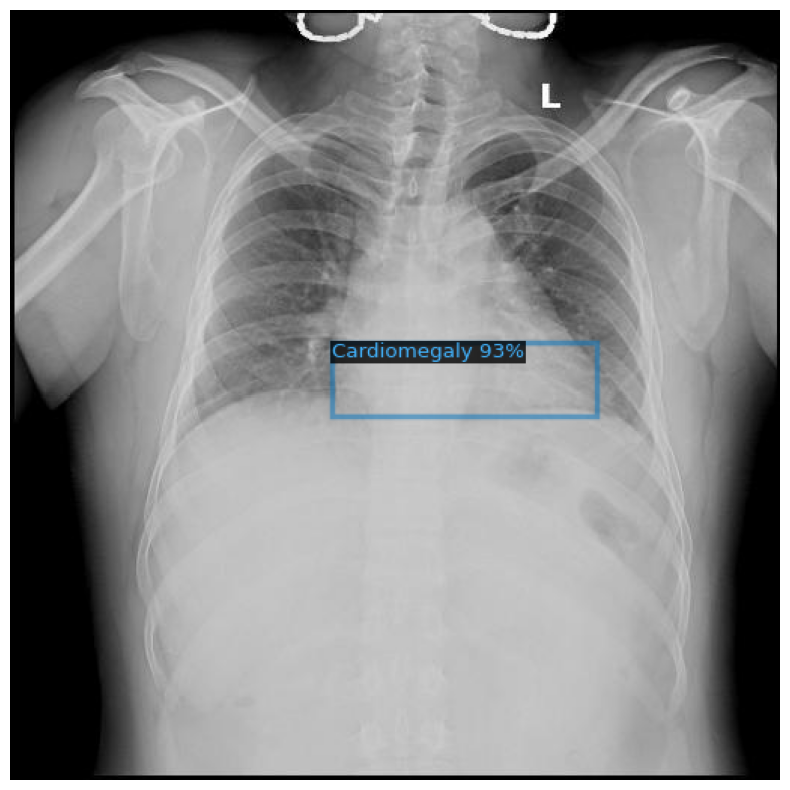

Detected 1 objects with confidence > 50.0%


In [ ]:
# 💡 Load the config file (you still need this to define model structure)
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/epoch_50_1e-4_Adam/config.yaml")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set score threshold

# 🔍 Set path to best model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/epoch_50_1e-4_Adam/best_model.pth"

# 🔧 Build model manually (optional alternative to DefaultPredictor if you want more control)
predictor = DefaultPredictor(cfg)

# 🖼️ Load and run inference on an image
image_path = '/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/test/9ed1f91369552618456da255b02820b3_jpg.rf.17cd671024249e0b1f3a9e36be41a928.jpg'
im = cv2.imread(image_path)

outputs = predictor(im)

# Filter instances with confidence
confidence = 0.5
instances = outputs["instances"]
scores = instances.scores
filtered_instances = instances[scores > confidence]
print(filtered_instances)


# 🎨 Visualize
MetadataCatalog.get("roboflow_train").thing_classes = ["objects", "Cardiomegaly", "Nodule-Mass", "Pneumothorax"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("roboflow_train"), scale=1)
v = v.draw_instance_predictions(filtered_instances.to("cpu"))

plt.figure(figsize=(10, 10))
plt.imshow(v.get_image())
plt.axis("off")
plt.show()

print(f"Detected {len(filtered_instances)} objects with confidence > {confidence*100}%")


# **Evaluasi Data Train, Validation, dan Testing**

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_train",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_train", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/eval_train")
val_loader = build_detection_test_loader(cfg, "roboflow_train")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 12:36:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 12:36:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 12:36:11 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/14 12:36:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 12:36:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 12:36:11 d2.data.common]: Serializing 892 elements to byte tensors and concatenating them all ...
[06/14 12:36:11 d2.data.common]: Serialized dataset takes 0.30 MiB
[06/14 12:36:11 d2.checkpoint.dete

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_val", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/eval_valid")
val_loader = build_detection_test_loader(cfg, "roboflow_val")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 13:22:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 13:22:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:22:32 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/14 13:22:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 13:22:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 13:22:32 d2.data.common]: Serializing 111 elements to byte tensors and concatenating them all ...
[06/14 13:22:32 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/14 13:22:32 d2.checkpoint.dete

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Load config dan model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/best_model.pth"
cfg.MODEL.DEVICE = 'cpu'  # atau 'cpu'
cfg.DATASETS.TEST = ("roboflow_test_1",)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

evaluator = COCOEvaluator("roboflow_test_1", cfg, False, output_dir="/content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Model/new/epoch_50_1e-4_Adam/eval_test")
val_loader = build_detection_test_loader(cfg, "roboflow_test_1")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

results = inference_on_dataset(model, val_loader, evaluator)
print(results)

WARNING [06/14 13:19:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/14 13:19:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:19:09 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/14 13:19:09 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category   | #instances   |  category   | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-----------:|:-------------|
| abnormalities | 0            | Cardiomegaly | 36           | Nodule-Mass | 34           |
| Pneumothorax  | 40           |              |              |             |              |
|     total     | 110          |              |       

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

class PRF1Evaluator(DatasetEvaluator):
    def __init__(self, dataset_name, metadata, class_names=None):
        from detectron2.data import MetadataCatalog, DatasetCatalog
        self.metadata = MetadataCatalog.get(dataset_name)
        self.dataset_dicts = DatasetCatalog.get(dataset_name)
        self.class_names = class_names if class_names else self.metadata.thing_classes
        self.gts = []
        self.preds = []

        # Buat mapping image_id ke daftar ground truth class ID
        self.imgid_to_gt = {}
        for data in self.dataset_dicts:
            gt_classes = [ann["category_id"] for ann in data["annotations"]]
            self.imgid_to_gt[data["image_id"]] = gt_classes

    def reset(self):
        self.gts = []
        self.preds = []

    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            img_id = input["image_id"]
            gt_classes = self.imgid_to_gt.get(img_id, [])
            pred_classes = output["instances"].pred_classes.cpu().numpy() if len(output["instances"]) > 0 else []

            # Samakan panjang prediksi dan ground truth
            if len(pred_classes) < len(gt_classes):
                pred_classes = list(pred_classes) + [-1] * (len(gt_classes) - len(pred_classes))
            elif len(pred_classes) > len(gt_classes):
                pred_classes = pred_classes[:len(gt_classes)]

            self.gts.extend(gt_classes)
            self.preds.extend(pred_classes)

    def evaluate(self):
        print("\n==== Precision, Recall, and F1-Score per Class ====\n")

        # Ambil hasil sebagai dictionary
        report_dict = classification_report(
            self.gts,
            self.preds,
            target_names=self.class_names,
            output_dict=True,
            digits=3,
            zero_division=0
        )

        # Konversi ke DataFrame
        df = pd.DataFrame(report_dict).transpose()
        df.index.name = 'Class'

        # Ambil dan simpan nilai akurasi, hapus dari tabel supaya tampil rapi
        accuracy = report_dict.get("accuracy", None)
        if "accuracy" in df.index:
            df.drop("accuracy", inplace=True)

        # Ubah support menjadi integer
        if 'support' in df.columns:
            df['support'] = df['support'].astype(int)

        # Urutkan kolom
        df = df[['precision', 'recall', 'f1-score', 'support']]

        # Cetak tabel
        print(df.to_string(float_format="%.3f"))

        # Cetak akurasi secara terpisah
        if accuracy is not None:
            print(f"\nOverall Accuracy: {accuracy:.3f}")

        # Return hanya data, tanpa tampilkan dict sebagai output Python
        return


In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_train", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_train")
inference_on_dataset(trainer.model, test_loader, evaluator_test)


WARNING [06/14 13:43:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:43:52 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
WARNING [06/14 13:43:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:43:52 d2.data.datasets.coco]: Loaded 892 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/train/_annotations.coco.json
[06/14 13:43:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 13:43:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 13:43:52 d2.data.common]: Serializing 892 

{}

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_val", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_val")
inference_on_dataset(trainer.model, test_loader, evaluator_test)

WARNING [06/14 13:45:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:45:12 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
WARNING [06/14 13:45:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:45:12 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/valid/_annotations.coco.json
[06/14 13:45:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 13:45:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 13:45:12 d2.data.common]: Serializing 111 

{}

In [ ]:
class_names = ["Cardiomegaly", "Nodule/Mass", "Pneumothorax"]

evaluator_test = PRF1Evaluator("roboflow_test_1", cfg, class_names=class_names)
test_loader = build_detection_test_loader(cfg, "roboflow_test_1")
inference_on_dataset(trainer.model, test_loader, evaluator_test)

WARNING [06/14 13:45:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:45:39 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
WARNING [06/14 13:45:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/14 13:45:39 d2.data.datasets.coco]: Loaded 111 images in COCO format from /content/drive/MyDrive/210411100014_Taufiqu Reza Yoga Pratama/Dataset/dataset_new/test/_annotations.coco.json
[06/14 13:45:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/14 13:45:39 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/14 13:45:39 d2.data.common]: Serializing 111 el

{}